In [119]:
import numpy as np
import matplotlib.pyplot as plt

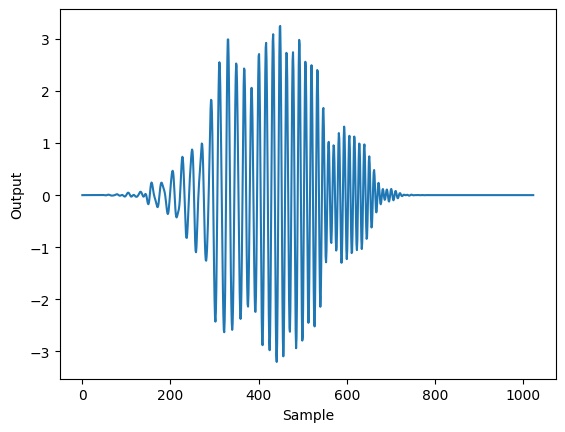

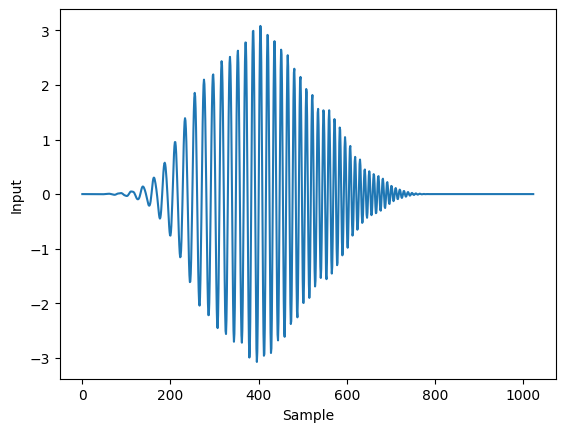

In [120]:
# Load dataset
data = np.genfromtxt("data/flutter.dat")
u = data[:,0]
y = data[:,1]
t_ = np.linspace(0, len(y)-1, len(y))

plt.figure()
plt.plot(t_, y)
plt.xlabel("Sample")
plt.ylabel("Output")

plt.figure()
plt.plot(t_, u)
plt.xlabel("Sample")
plt.ylabel("Input")
plt.show()

In [235]:
# Construct X and Y matrices for regression
NUM_DELAYS = 2
TRAIN_TEST_SPLIT = 0.4
LS_ORDER = 4
BETA = 10
assert NUM_DELAYS >= 1, "Delays must be a positive integer"
assert TRAIN_TEST_SPLIT > 0 and TRAIN_TEST_SPLIT < 1, "Train/test split must be between 0 and 1"
assert LS_ORDER >= 0, "Model order must be non-negative"

# Split into train and test sets
train_test_index = int(len(y)*TRAIN_TEST_SPLIT)
y_train = y[:train_test_index]
y_test  = y[train_test_index:]
u_train = u[:train_test_index]
u_test  = u[train_test_index:]

# Construct training data
Y_train = np.expand_dims(y_train[NUM_DELAYS:], axis=1)
X_train = np.zeros(shape=(len(y_train)-NUM_DELAYS, 2*NUM_DELAYS))
for i in range(len(y_train)-NUM_DELAYS):
    X_train[i,:NUM_DELAYS] = y_train[i:i+NUM_DELAYS]
    X_train[i,NUM_DELAYS:] = u_train[i:i+NUM_DELAYS]


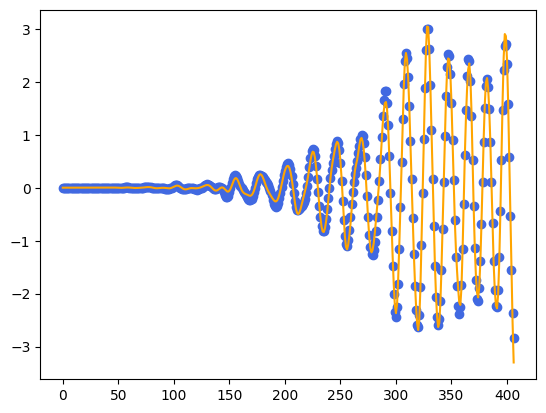

In [236]:
# Construct LS model
def construct_H(X, model_order):
    dp, features = X.shape
    H = np.ones(shape=(dp,1))
    for order in range(1,model_order+1):
        for i in range(features):
            for j in range(i, features):
                if j == i:
                    H_ = np.power(X[:,[i]], order)
                    H = np.hstack((H, H_))
                else:
                    for k in range(1, order):
                        H_ = np.multiply(np.power(X[:,[i]], k), np.power(X[:,[j]], order-k))
                        H = np.hstack((H, H_))
    return H

def model_ls(x, w, model_order):
    h_ = construct_H(x, model_order)
    y_ = h_ @ w
    return y_

# Get model params
H_train = construct_H(X_train, LS_ORDER)
w = np.linalg.inv(H_train.T @ H_train + BETA*np.eye(H_train.shape[1])) @ H_train.T @ Y_train

# Plot training results
t_ = np.linspace(0, Y_train.shape[0]-1, Y_train.shape[0])
Y_pred_train = model_ls(X_train, w, model_order=LS_ORDER)
plt.scatter(t_, Y_train, c="royalblue")
plt.plot(t_, Y_pred_train, c="orange")
plt.show()



In [237]:
# Testing loop
Y_pred_test = np.zeros(shape=(0,1))
for i in range(len(y_test)):
    if i < NUM_DELAYS:
        Y_pred_test = np.vstack((Y_pred_test, y_test[i]))
    else:
        X_ = np.hstack(([Y_pred_test[-NUM_DELAYS:,0]], [u_test[i-NUM_DELAYS:i]]))
        print(i, X_.shape)
        Y_pred_ = model_ls(X_, w, model_order=LS_ORDER)
        Y_pred_test = np.vstack((Y_pred_test, Y_pred_))
        # print(X_.shape, Y_.shape, Y_pred_.shape, Y_pred_test.shape)
Y_pred_test = Y_pred_test.flatten()

2 (1, 4)
3 (1, 4)
4 (1, 4)
5 (1, 4)
6 (1, 4)
7 (1, 4)
8 (1, 4)
9 (1, 4)
10 (1, 4)
11 (1, 4)
12 (1, 4)
13 (1, 4)
14 (1, 4)
15 (1, 4)
16 (1, 4)
17 (1, 4)
18 (1, 4)
19 (1, 4)
20 (1, 4)
21 (1, 4)
22 (1, 4)
23 (1, 4)
24 (1, 4)
25 (1, 4)
26 (1, 4)
27 (1, 4)
28 (1, 4)
29 (1, 4)
30 (1, 4)
31 (1, 4)
32 (1, 4)
33 (1, 4)
34 (1, 4)
35 (1, 4)
36 (1, 4)
37 (1, 4)
38 (1, 4)
39 (1, 4)
40 (1, 4)
41 (1, 4)
42 (1, 4)
43 (1, 4)
44 (1, 4)
45 (1, 4)
46 (1, 4)
47 (1, 4)
48 (1, 4)
49 (1, 4)
50 (1, 4)
51 (1, 4)
52 (1, 4)
53 (1, 4)
54 (1, 4)
55 (1, 4)
56 (1, 4)
57 (1, 4)
58 (1, 4)
59 (1, 4)
60 (1, 4)
61 (1, 4)
62 (1, 4)
63 (1, 4)
64 (1, 4)
65 (1, 4)
66 (1, 4)
67 (1, 4)
68 (1, 4)
69 (1, 4)
70 (1, 4)
71 (1, 4)
72 (1, 4)
73 (1, 4)
74 (1, 4)
75 (1, 4)
76 (1, 4)
77 (1, 4)
78 (1, 4)
79 (1, 4)
80 (1, 4)
81 (1, 4)
82 (1, 4)
83 (1, 4)
84 (1, 4)
85 (1, 4)
86 (1, 4)
87 (1, 4)
88 (1, 4)
89 (1, 4)
90 (1, 4)
91 (1, 4)
92 (1, 4)
93 (1, 4)
94 (1, 4)
95 (1, 4)
96 (1, 4)
97 (1, 4)
98 (1, 4)
99 (1, 4)
100 (1, 4)
101 (1, 4)
102 (1

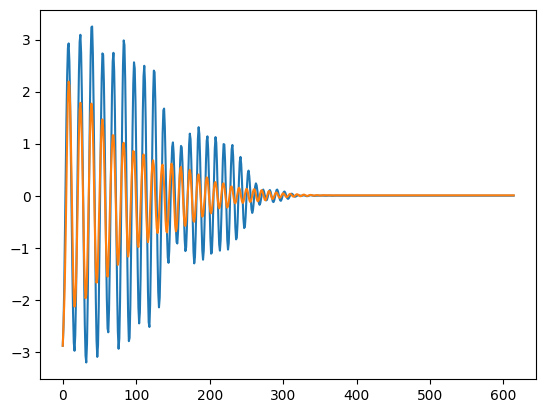

In [238]:
plt.plot(y_test)
plt.plot(Y_pred_test)

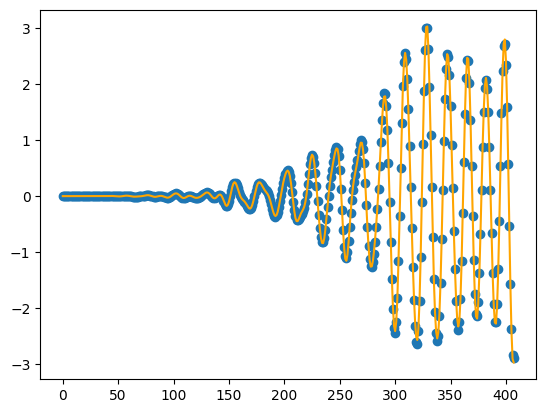

In [117]:
t_ = np.linspace(0, Y_train.shape[0]-1, Y_train.shape[0])
plt.scatter(t_, Y_train)
# plt.scatter(t_, y_pred_train, color="orange")
plt.plot(t_, y_pred_train, color="orange")
# plt.xlim([200, 210])
plt.show()

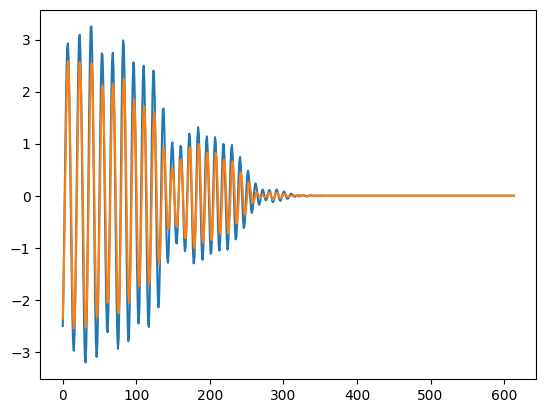

In [106]:
plt.plot(Y_test)
plt.plot(y_pred_test)
plt.show()

In [155]:
arr = np.array([[0],[1],[2],[3],[4]])

In [167]:
print(arr)

[[0]
 [1]
 [2]
 [3]
 [4]]


In [177]:
print(arr[-3:,:].flatten())

[2 3 4]


In [175]:
i= 5 
print(u_test[i:i+NUM_DELAYS+1])

[-2.4689796 -1.6383453]
